Fill in the missing code. The lines with missing code have the string "#####"
"INSTRUCTIONS" comments explain how to fill in the mising code.

In this notebook you will learn an important piece of information:
how to take advantage of scikit-learn'a parameter optimization routines 
to optimize parameters in the Ta-lib functions.
For this we will use a combination of FunctionTransformer and ColumnTransformer.

The Ta-lib functions are very useful for feature engineering but
you have to know what values to set to the various Ta-lib function parameters.

Most parameters in the Ta-lib functions have default values but
the values are optimal only for daily trading, and 
only for an index like the S&P500 or a typical stock.
If your model is predicting in a different timeframe or
if your model is predicting an atypical stock, then
you will probably have to search to optimize the parameters of the Ta-lib functions.
So here you will learn how to use scikit-learn to help you optimize Ta-lib.

As an example, we will use a smoothing Ta-lib function: EMA which
stands for exponential moving average or "exponential smoothing".

In finance, smoothing techniques are sometimes used to remove noise from the input data.
In this notebook you will use the scikit-learn utility FunctionTransformer
to extend the scikit-learn's input pre-processing capabilities
to apply and optimize exponential smoothing.

Exponential smoothing is implemented in both Pandas and in Ta-lib.
We shall see both implementations.

In Pandas:
pandas.DataFrame.ewm, also known as
panda's exponential moving window,
that is documented here:
https://archive.is/p92xp
https://archive.is/HhPAu

In Pandas' ewm: 
there is averaging implemented by the mean function (ewm(span=span, adjust=True).mean()) 
averaging is over a moving window (ewm) of length equal to span
the averaging is exponentially weighted and
the weights decay exponentially so as to
decrease the importance of oldest input in the window (input at the start or left-edge of the window) 
increase the importance of newest input in the window  (input at the end or right-edge of the window)
For more information, you can (optionally) read the material in the EWM_PANDAS folder.
Exponential smoothing can also be used for prediction as explained in ExponentialSmoothing.pptx
but in this notebook we use it for noise reduction only.

In Ta-lib:
Exponential smoothing in Ta-lib is implemented with the function:
real = EMA(close, timeperiod=30)
that is documented here:
https://archive.is/CvJo0

Clearly, applying any kind of smoothing,
including Panda's and Ta-lib's ewm,
requires the preservation of the original order of the input samples.
Thefore, Panda's and Ta-lib's ewm must be used in combination with TimeSeriesSplit.
Here we show you how to do this also.
In any case, when it comes to financial series prediction,
it is a good idea to use TimeSeriesSplit, whether
you use smoothing or not.

So far you have seen the operation of two data fold splitters
during the cross-validation process.
In On_regression_start_part1.pptx slide 30,
you saw the operation of the regular Kfold splitter.
In On_regression_start_part2.pptx slide 16
you saw the operation of a special splitter called TimeSeriesSplitter.

These two splitters are set side by side here:
https://archive.is/f8RPm
(the pdf of this file is included with this homework:
Visualizing cross-validation — scikit-learn 0.24.2 documentation.pdf)
where the training folds are shown in blue, the validation folds in red.
Kfold is the first splitter shown, 
TimeSeriesSplitter is the last one at the bottom of the page.

The two splitters have one similarity and one difference.

The similarity is that they both have one validation fold per iteration.

The difference is that 
if you think of the data being split as a time series,
the TimeSeriesSplitter splitter creates training folds from strips of data that are continuous in time.
The Kfold splitter creates training folds by splicing together two strips that
were not originally adjacent in time.
So Kfold does not respect the original time structure.

In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# import io
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")
# df = pd.read_csv(io.BytesIO(uploaded['USDCAD_H3_200001030000_202107201800.csv']), sep='\t')
df = pd.read_csv('/content/drive/MyDrive/ML/Assignment 1/USDCAD_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the close and open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open

In [ ]:
##build window momentum features
for n in list(range(1,30)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n)#for trading with open
    
#build date time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

In [ ]:
#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

In [ ]:
#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

In [ ]:
#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df.drop(cols_to_drop, axis=1, inplace=True)

#distribute the df data into X inputs and y target
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]

In [ ]:
#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

In [ ]:
# download TA-Lib 
# required only on google colab
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
# !tar xvzf ta-lib-0.4.0-src.tar.gz
# !ls
# import os
# os.chdir('ta-lib') # Can't use !cd in co-lab
# !./configure --prefix=/usr
# !make
# !make install
# os.chdir('../')
# !ls
# !pip install TA-Lib

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
import talib as ta

In [ ]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho

def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio

INSTRUCTIONS
Write two versions of the exponential smoothing called pandas_ewm_smoother and talib_ewm_smoother. 
Note that inside the pandas_ewm_smoother function, 
you call the corresponding Pandas function,
as per ExponentialSmoothing.pptx with adjust=True.
Similarly inside the talib_ewm_smoother function,
you call the corresponding Ta-lib function.
We will use pandas_ewm_smoother and talib_ewm_smoother inside the FunctionTransformer object.
This is worth 2 points.

In [ ]:
#PANDAS exponential smoothing:
def pandas_ewm_smoother(x, span=10):
  df = pd.DataFrame(x)
  return df.ewm(span=span, adjust=True).mean()

#Ta-lib exponential smoothing:
def talib_ewm_smoother(x, span=10):
  df = pd.DataFrame(x)
  return df.apply(lambda col: ta.EMA(col.values, timeperiod=10), axis=0)

In [ ]:
myscorer = make_scorer(information_coefficient, greater_is_better=True)

INSTRUCTIONS
For proper functioning of exponetial smoothing,
make sure that TimeSeriesSplit is being activated during RandomizedSearchCV and GridSearchCV
to presere the chronological order of the input series during the construction of the folds.
TimeSeriesSplit is documented here:
https://archive.is/8FZtM
Change the value of split from split=5 to the split created by TimeSeriesSplit with
n_splits set to 5 and max_train_size set to 2000.
This is worth 1 point.

In [ ]:
#when using smoother, use TimesSeriesSplit
split = TimeSeriesSplit(n_splits=5, max_train_size=2000)

INSTRUCTIONS
To use the exponential smoothing functions you need to use the FunctionTransformer object.
The instructions for the FunctionTransformer object are here:
https://archive.is/hsurj

Instantiate a FunctionTransformer object.
Assign the ewm_smoother function or the pandas_smoother_function to the FunctionTransformer object's func parameter.
Save the resulting object in "smoother".
Do this twice, once for pandas_ewm_smoother and again for talib_ewm_smoother.
Each time, assign the resulting object to smoother.
What the FunctionTranformer object is doing is wrapping around the original function 
and provide it with a fit_transform method.
This is worth 2 points.

In [ ]:
#Note: transformer 3-element tuples can be: ['name', function or pipeline, column_number_list or column_index]
smoother = FunctionTransformer(func=pandas_ewm_smoother)
# smoother = FunctionTransformer(func=talib_ewm_smoother)

INSTRUCTIONS
Note that pandas_ewm_smoother and talib_ewm_smoother have an argument called span that needs to be optimized.
Put possible span values in a list, for guidance see: https://archive.is/RPs90
This is worth 1 pont.

In [ ]:
####
span_params = [{'span': 5}, {'span': 10}, {'span': 15}, {'span': 20}, {'span': 25}, {'span': 30}]

The tricky part is to construct the parameter grid correctly.
Start by proposing a key like 'preprocessor__kw_args' (it is the wrong key but close enough)
You will get an error.
Following the instructions of the error message:
Print out the list of possible keys by printing out: grid_search.get_params().keys()
Find the correct key and substitute it instead of 'preprocessor__kw_args'
This is worth 2 points.

In [ ]:
#helpful for setting up param_grid: grid_search.get_params().keys()
####
numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('scaler', StandardScaler()),
    ('smoother', smoother),
    ('imputer2', SimpleImputer(strategy='constant', fill_value=0))])

categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#Note: transformer 3-element tuples can be: ['name', function or pipeline, column_number_list or column_index]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

ridge = Ridge(max_iter=1000) 
ridge_params = [1000,500,100,50,10,5,1,.5,.1]

pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ridge', ridge)])
param_grid = [{'preprocessor__num__smoother__kw_args': span_params, 'ridge__alpha': ridge_params}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer)
grid_search.fit(x_train,y_train.retFut1.ravel())

0.04275070908836684
0.06863703538388062
0.025216397989738116
0.06385411815592457
0.05021472907751545
0.05258072127143604
0.07505312484694791
0.029863147065634033
0.057905414339087156
0.054214734750553134
0.032249127073067166
0.060385592562954664
0.009925827475279021
0.06794346713951697
0.05642552122179991
0.05859953134981217
0.07737737272091916
0.03654509537099232
0.052800534491493786
0.056167654783436785
0.047946172515225316
0.0718504540441845
0.02584193839798245
0.05929983055144707
0.05385391299796162
0.08122345392050029
0.08526320023632641
0.05116172720701536
0.0674651999217684
0.04818981493467342
0.06644395955223023
0.08293523349724459
0.047088533770370214
0.06497644128813596
0.058499533935882586
0.07644967336367291
0.08341291432449265
0.050310688930544044
0.06526966003860517
0.050095970716189105
0.03404807859815408
0.06450024691112587
0.0151532364165256
0.07123016651481467
0.050796881723914944
0.08600842352325194
0.08294592296367204
0.05083409716777065
0.06379335703780485
0.045505

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=2000, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0.0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('smoother',
                                                                                                FunctionTransformer(func=<function pa...
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index(['hour', 'day'], dtype='object'))])),
                                             ('ridge', Ridge(max_iter=1000))]),
                   param_distributions=[{'preprocessor__num__smoother__kw_args': [{'span': 5},
                                                                                  {'span': 10},
                                                                                  {'span': 15},
                                                                                  {'span': 20},
                                                                                  {'span': 25},
                                                                                  {'span': 30}],
                                         'ridge__alpha': [1000, 500, 100, 50,
                                                          10, 5, 1, 0.5,
                                                          0.1]}],
                   scoring=make_scorer(information_coefficient))

In [ ]:
# grid_search.get_params().keys()

In [ ]:
grid_search.best_params_

{'ridge__alpha': 1, 'preprocessor__num__smoother__kw_args': {'span': 5}}

In [ ]:
grid_search.best_score_

0.06666067924405679

In [ ]:
# Train set
# Make "predictions" on training set (in-sample)
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

dailyRet = pd.Series(positions).fillna(0).values * y_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

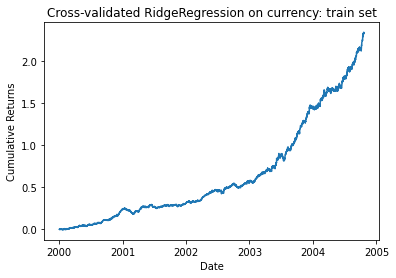

In [ ]:
plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated RidgeRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))

In [ ]:
def calculateMaxDD(cumret):
    highwatermark = np.zeros(len(cumret))
    drawdown      = np.zeros(len(cumret))
    drawdownduration = np.zeros(len(cumret))
    for t in range(1, len(cumret)):
        highwatermark[t] = np.max([highwatermark[t-1], cumret[t]])
        drawdown[t] = (1+cumret[t]) / (1 + highwatermark[t]) - 1
        if (drawdown[t]==0):
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    return np.min(drawdown), np.max(drawdownduration)

In [ ]:
cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

In-sample: CAGR=0.0308043 Sharpe ratio=1.2046 maxDD=-0.0598594 maxDDD=785 Calmar ratio=0.514611



In [ ]:
# Test set
# Make "predictions" on test set (out-of-sample)
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

dailyRet2 = pd.Series(positions2).fillna(0).values * y_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

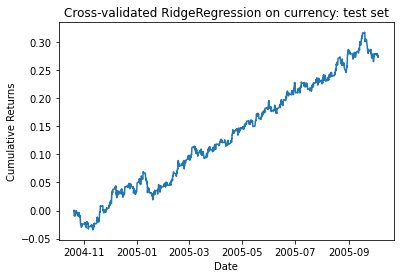

In [ ]:
plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RidgeRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

In [ ]:
rho, pval = spearmanr(y_test,grid_search.predict(x_test)) #spearman's rank correlation: very small but significant

In [ ]:
cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))

Out-of-sample: CAGR=0.0309038 Sharpe ratio=0.954757 maxDD=-0.046956 maxDDD=213 Calmar ratio=0.658143  Rho=0.104224 PVal=2.99934e-06



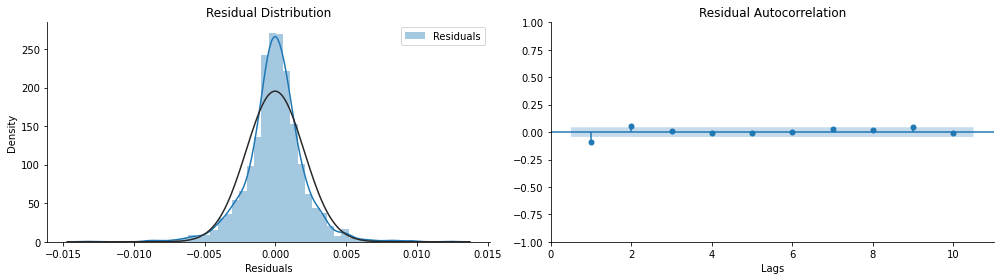

In [ ]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test).ravel()
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))

In [ ]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
lb.head()
# print("Ljung-Box test p-value", lb[1])

,lb_stat,lb_pvalue
10,28.129556,0.001721


In [ ]:
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid

In [ ]:
# White Reality check
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)


    
    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
   # plt.show()
    

    #about the histogram
    #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
    #R(n^(1/3))/(3.49σ)
    #R is the range of data (in your case R = 3-(-3)= 6),
    #n is the number of samples,
    #σ is your standard deviation.


average return 0.002614
[-0.0029089   0.00288739]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.035800000000000054


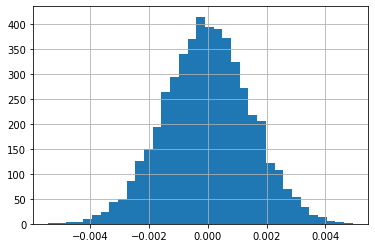

In [ ]:
#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)
plt.show()

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
column_names = numeric_features_ix.values.tolist()
num_dummies = len(best_model[1].coef_.ravel().tolist())-len(column_names)
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

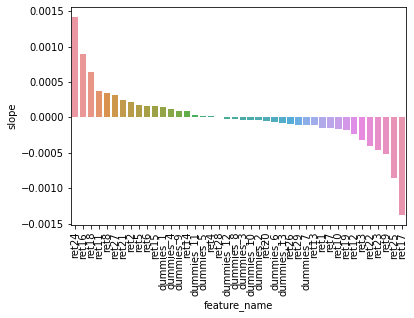

In [ ]:
#plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))

QUESTIONS:
FunctionTransformer wraps a custom function into an object that has the fit_transform method:
What do you get when you increase the pandas_ewm_smoother span parameter to 10 and run the following code?
This is worth 1 point.

In [ ]:
####
smoother = FunctionTransformer(pandas_ewm_smoother, kw_args={'span':10})
x_train_in = x_train.drop(['hour','day'], axis=1)
x_train_out = smoother.fit_transform(x_train_in)

In [ ]:
smoother_5 = FunctionTransformer(pandas_ewm_smoother, kw_args={'span':5})
x_train_out_5 = smoother_5.fit_transform(x_train_in)

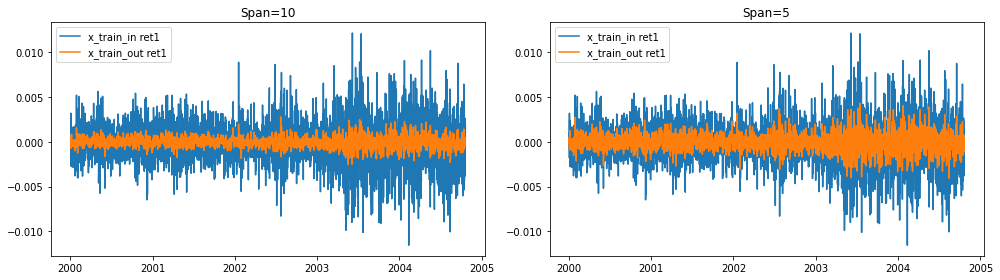

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
axes[0].plot(x_train_in['ret1'])
axes[0].plot(x_train_out['ret1'])
axes[0].legend(['x_train_in ret1', 'x_train_out ret1'])
axes[0].set_title('Span=10')
axes[1].plot(x_train_in['ret1'])
axes[1].plot(x_train_out_5['ret1'])
axes[1].legend(['x_train_in ret1', 'x_train_out ret1'])
axes[1].set_title('Span=5')
fig.tight_layout();
plt.show()

-> Higher span smoothens the input so we can see range of input reduces in span=10 as compared to span=5.

-----

When predicting returns, is it better apply exponential smoothing to prices or to returns?
Try both by changing
This is worth 1 point.

-> It is better to apply exponential smoothing to prices as prices have a better signal to noise ratio as compared to returns.

In [ ]:
openr = openp.pct_change().fillna(0.0)

In [ ]:
smoother = FunctionTransformer(pandas_ewm_smoother, kw_args={'span':100})
openp_out = smoother.fit_transform(openp)
openr_out = smoother.fit_transform(openr)
openp_r = openp_out.pct_change().fillna(0.0)

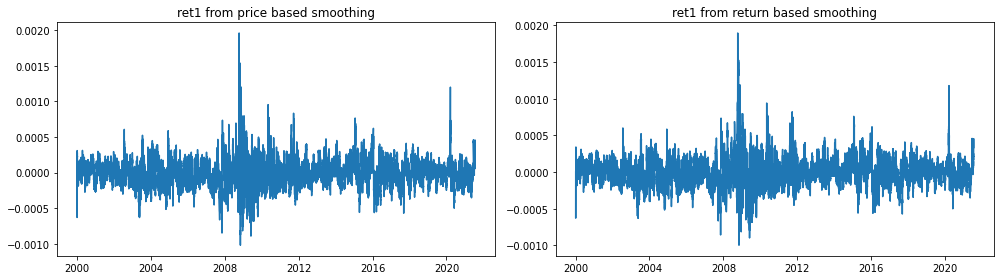

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
axes[0].plot(openp_r)
axes[0].set_title('ret1 from price based smoothing')
axes[1].plot(openr_out)
axes[1].set_title('ret1 from return based smoothing')
fig.tight_layout();
plt.show()